In [1]:
import sys
sys.path.append("..")

# basics
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import copy
import qutip
from tqdm import tqdm as tqdm

# custom stuff
import system.from_higher_basis_truncation_tunable_full_cosine as system
import utils.solver as solver
import pulse.tukey as tukey
import pulse.tanh as tanh
import utils.expectation_values as expv
import utils.graph as graph
import utils.saver as saver

# parallel utils
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor

pass

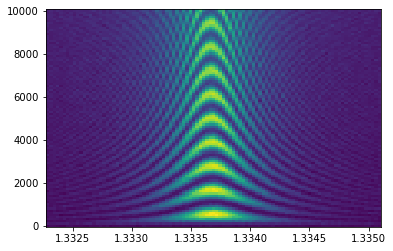

In [59]:
# create experimental graphs
plt.pcolormesh(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp0.15_Freq.csv", header=None)[0].to_list(), pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp0.15_pulseLength.csv", header=None)[0].to_list(), -1*np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp0.15.csv", header=None).values.tolist()).transpose(), shading='auto')
plt.show()

In [33]:
# create experimental graphs
fids = np.array(pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp0.3.csv", header=None).values.tolist()).transpose()
freq_list = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp0.3_Freq.csv", header=None)[0].to_list()
dur_list = pd.read_csv("../mingkang_graphing/timeRabi/TimeRabi_amp0.3_pulseLength.csv", header=None)[0].to_list()

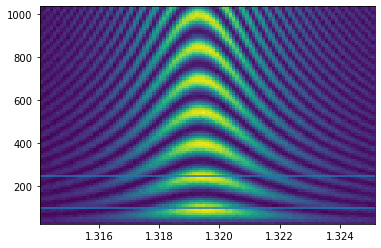

In [45]:
plt.pcolormesh(freq_list, dur_list, -1*fids, shading='auto')
plt.axhline(100)
plt.axhline(245)
plt.show()

In [4]:
(system.first_energy_spacing/3 - 0.08) / (2 * np.pi)

1.3109948702645484

In [8]:
# # sweep through params to find where fidelity at duration = 100 is maximized
# # just use data from as_function_of_amplitude to find the correct amp and offset pair to match!
# offset = 0.08
# guess_amplitude = 8
# duration = 100
# ramp_slope = 0.5
# cut_factor = 3

# def cost(parameters, constants):
#     # parameters = [offset, duration]
#     offset = parameters[1]
#     duration = constants[0]
#     # constants = [amplitude, ramp_coeff]
#     amplitude = parameters[0]
#     ramp_slope = constants[1]
#     cut_factor = constants[2]
#     tlist = np.linspace(0, duration, int(duration*5))
#     tanh.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
#     solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tanh.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
#     expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
#     fidelity = expectation_values[1][-1]
#     print(fidelity, amplitude, offset)
#     return (1-fidelity)

# result1 = sp.optimize.minimize(cost, [guess_amplitude, offset], [duration, ramp_slope, cut_factor], method="Nelder-Mead", options={"disp":True})

In [11]:
t_multiplier = 5
amplitude = 10
freq = 8
ramp_slope = 0.5
cut_factor = 3
def inner(dur):
    tlist = np.linspace(0, dur, int(dur*t_multiplier))
    tanh.setup(amplitude=amplitude, drive_frequency=freq, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
    s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state)
    fidelity = expv.expectation_value(s.states[-1], system.target_state)
    return fidelity

def generate_fidelity_landscape(_amplitude, _ramp_slope, _cut_factor, freq_list, dur_list, _t_multiplier=5, skip_rate=1):
    global t_multiplier, amplitude, freq, ramp_slope, cut_factor
    t_multiplier = _t_multiplier
    amplitude = _amplitude
    ramp_slope = _ramp_slope
    cut_factor = _cut_factor
    fids = [] # an array of columns in the landscape
    freq_points = np.linspace(np.amin(freq_list), np.amax(freq_list), int(len(freq_list)/skip_rate))
    dur_points = np.linspace(np.amin(dur_list), np.amax(dur_list), int(len(dur_list)/skip_rate))
    for f in tqdm(freq_points):
        freq = f
        fids.append(parallel_map(inner, dur_points))

    fids = np.swapaxes(fids,0,1)

    plt.pcolormesh(freq_points, dur_points, fids, shading='auto')
    plt.colorbar()
    plt.xlabel("frequency (GHz)")
    plt.ylabel("duration (ns)")
    
    return fids

100%|██████████| 50/50 [1:45:04<00:00, 126.10s/it]


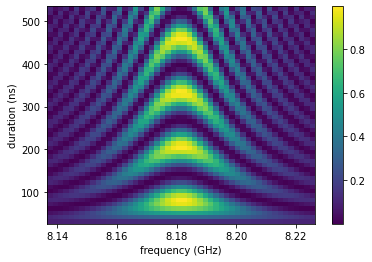

In [20]:
amplitude_guess = 8.03890342376912
my_freq_list = (np.array(freq_list)* 2 * np.pi)-0.05
theory1 = generate_fidelity_landscape(amplitude_guess, 0.5, 3, np.array(my_freq_list), dur_list, 2, 2)

In [21]:
saver.save(theory1, "Nov19_fit_to_mingkang")

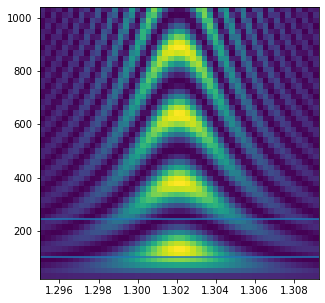

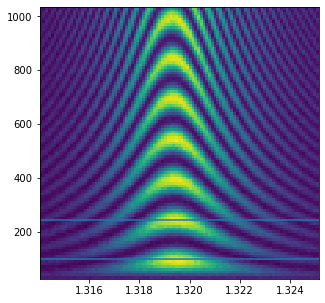

In [46]:
freq_points1 = np.linspace(np.amin(my_freq_list), np.amax(my_freq_list), int(len(my_freq_list)/2))
dur_points1 = np.linspace(np.amin(dur_list), np.amax(dur_list), int(len(dur_list)/2))
plt.figure(figsize=(5,5))
plt.axhline(100)
plt.axhline(245)
plt.pcolormesh(freq_points1 / (2*np.pi), dur_points1, theory1, shading='auto')
plt.figure(figsize=(5,5))
plt.axhline(100)
plt.axhline(245)
plt.pcolormesh(freq_list, dur_list, -1*fids, shading='auto')


In [52]:
(np.amax(freq_points1 / (2*np.pi)) - np.amin(freq_points1 / (2*np.pi)))

0.014000000000000012

In [53]:
(np.amax(freq_list) - np.amin(freq_list))

0.01100000000000012

100%|██████████| 25/25 [1:09:42<00:00, 167.30s/it]


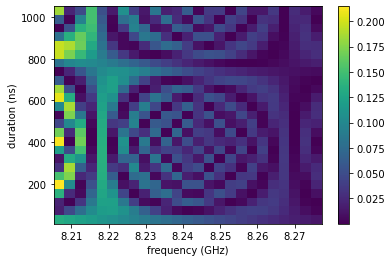

In [55]:
amplitude_guess = 8.32600711747516
my_freq_list2 = (np.array(freq_list)* 2 * np.pi)-0.05
theory2 = generate_fidelity_landscape(amplitude_guess, 0.5, 3, np.array(my_freq_list2), dur_list, 2, 4)

100%|██████████| 16/16 [24:11<00:00, 90.73s/it]


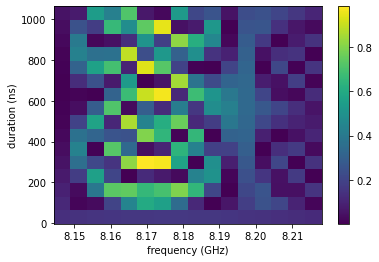

In [57]:
amplitude_guess = 8.32600711747516
my_freq_list2 = (np.array(freq_list)* 2 * np.pi)-0.11
theory3 = generate_fidelity_landscape(amplitude_guess, 0.5, 3, np.array(my_freq_list2), dur_list, 2, 6)